# Chapter 5 - Introduction to Neural Networks for Time Series Forecasting

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common.utils import load_data, mape
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [15]:
data_dir = "data/"
ts_data_load = load_data(data_dir)[["load"]]
ts_data_load.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


In [16]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

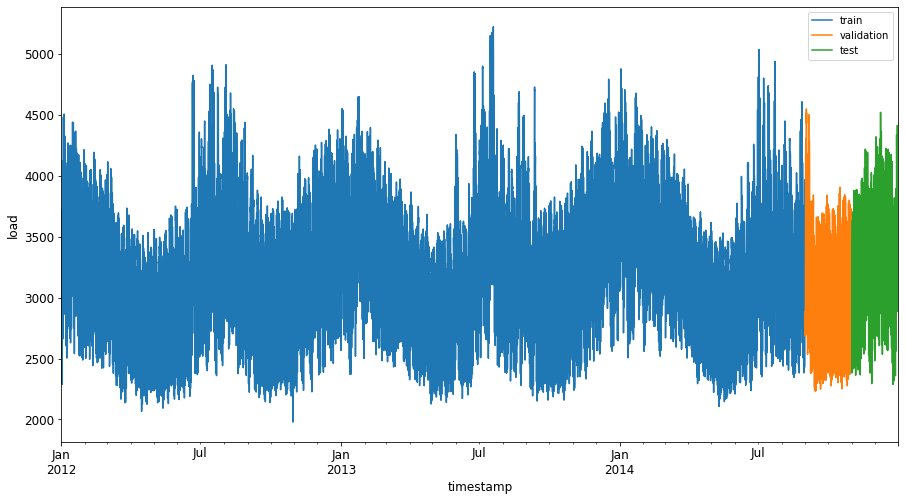

In [17]:
ts_data_load[ts_data_load.index < valid_st_data_load][["load"]].rename(columns={"load": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["load"]
    ].rename(columns={"load": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["load"]].rename(columns={"load": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [18]:
T = 6
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][["load"]]

scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


In [19]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [20]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [21]:
y_train.shape

(23370,)

In [22]:
y_train[:3]

array([0.18, 0.23, 0.29])

In [23]:
X_train.shape

(23370, 6, 1)

In [24]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [25]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


In [26]:
look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)][
    ["load"]
]

valid["load"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load_t-" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [27]:
y_valid = valid_shifted["y+1"].as_matrix()
X_valid = valid_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

AttributeError: 'Series' object has no attribute 'as_matrix'

In [13]:
y_valid.shape

NameError: name 'y_valid' is not defined

In [ ]:
y_valid[:3]

In [ ]:
X_valid.shape

In [ ]:
X_valid[:3]

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = (
    10
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="RMSprop", loss="mse")

In [ ]:
model.summary()

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [ ]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

In [ ]:
look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
test = ts_data_load.copy()[test_st_data_load:][["load"]]

test["load"] = scaler.transform(test)

test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load_t-" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted["y_t+1"].as_matrix()
X_test = test_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [ ]:
y_test.shape

In [ ]:
X_test.shape

In [ ]:
ts_predictions = model.predict(X_test)
ts_predictions

In [ ]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

In [ ]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [ ]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

In [ ]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

## Multivariate model

In [29]:
import datetime as dt
import os
import sys
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common.utils import TimeSeriesTensor, create_evaluation_df, load_data, mape
from IPython.display import Image

%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [30]:
data_dir = "./data/"
ts_data = load_data(data_dir)
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [31]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [32]:
T = 6
HORIZON = 1

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [35]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

In [36]:
train.head()

,load,temp
2012-01-01 00:00:00,0.22,0.42
2012-01-01 01:00:00,0.18,0.43
2012-01-01 02:00:00,0.14,0.40
2012-01-01 03:00:00,0.13,0.41
2012-01-01 04:00:00,0.13,0.42


In [37]:
tensor_structure = {"X": (range(-T + 1, 1), ["load", "temp"])}
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="load",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data.copy()[(ts_data.index >= back_ts_data) & (ts_data.index < test_st_data_load)][
    ["load", "temp"]
]
valid[["load", "temp"]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "load", HORIZON, tensor_structure)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [39]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [40]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 135       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

In [ ]:
back_ts_data = dt.datetime.strptime(ts_data_test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
ts_data_test = ts_data.copy()[ts_data_test_st_data_load:][["load", "temp"]]
ts_data_test[["load", "temp"]] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "load", HORIZON, tensor_structure)

ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.head()

In [ ]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])